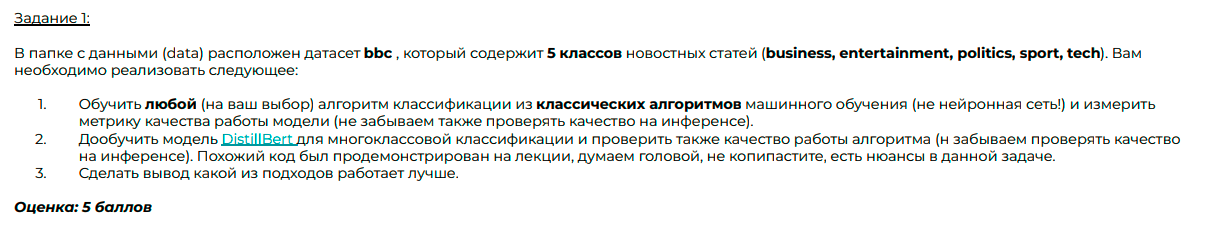

In [1]:
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import torch
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
!pip install transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, DistilBertConfig, TrainingArguments, Trainer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install datasets
import datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install watermark --quiet
%load_ext watermark
%watermark -a 'Anrei Sech' -v -p torch

Author: Anrei Sech

Python implementation: CPython
Python version       : 3.7.14
IPython version      : 7.9.0

torch: 1.12.1+cu113



In [3]:
BATCH_SIZE = 16
NUM_EPOCHS = 1
RANDOM_SEED = 42
LEARNING_RATE = 5e-5
STOPWORDS = set(stopwords.words('english'))
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

# Data Loading

In [4]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [5]:
parent_folder = '/drive/My Drive/NLP/data/bbc/'
os.listdir(parent_folder)

['business', 'entertainment', 'sport', 'tech', 'politics']

In [6]:
def extract_file_content(parent_folder):
    categories = []
    captions = []
    content = []
    file_names = []

    for folder in os.listdir(parent_folder):
        category = os.path.basename(folder)

        category_folder = os.path.join(parent_folder, folder)
        for file in os.listdir(category_folder):
            data = ''
            with open(os.path.join(category_folder, file), mode='r', encoding='utf8', errors='ignore') as f:
                file_content = f.readlines()
                caption = file_content[0]
                data = file_content
                data = ' '.join(data)
            categories.append(category)
            captions.append(caption)
            content.append(data)
            file_names.append(os.path.basename(file))

    return categories, captions, content, file_names

In [7]:
categories, captions, full_content, file_names = extract_file_content(parent_folder)
data_dict = { 'category' : categories, 'filename' : file_names, 'caption' : captions, 'news': full_content }
df = pd.DataFrame(data_dict)
df.to_csv('./bbc.csv')

In [8]:
df.head()

,category,filename,caption,news
0,business,001.txt,Ad sales boost Time Warner profit\n,Ad sales boost Time Warner profit\n \n Quarter...
1,business,004.txt,High fuel prices hit BA's profits\n,High fuel prices hit BA's profits\n \n British...
2,business,002.txt,Dollar gains on Greenspan speech\n,Dollar gains on Greenspan speech\n \n The doll...
3,business,003.txt,Yukos unit buyer faces loan claim\n,Yukos unit buyer faces loan claim\n \n The own...
4,business,006.txt,Japan narrowly escapes recession\n,Japan narrowly escapes recession\n \n Japan's ...


category
business         510
entertainment    386
politics         417
sport            511
tech             401
Name: news, dtype: int64


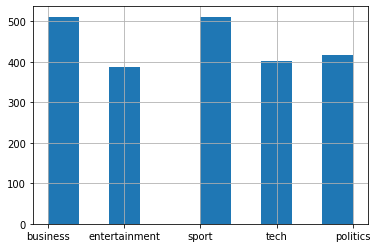

In [9]:
print(df.groupby('category')['news'].count())
df["category"].hist();

# Data Prepocessing

## Encode the labels into numeric

In [10]:
le = sklearn.preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['category'])
df.head()

,category,filename,caption,news,label
0,business,001.txt,Ad sales boost Time Warner profit\n,Ad sales boost Time Warner profit\n \n Quarter...,0
1,business,004.txt,High fuel prices hit BA's profits\n,High fuel prices hit BA's profits\n \n British...,0
2,business,002.txt,Dollar gains on Greenspan speech\n,Dollar gains on Greenspan speech\n \n The doll...,0
3,business,003.txt,Yukos unit buyer faces loan claim\n,Yukos unit buyer faces loan claim\n \n The own...,0
4,business,006.txt,Japan narrowly escapes recession\n,Japan narrowly escapes recession\n \n Japan's ...,0


## Text Preprocessing

*Tokenization, stopwords*

In [11]:
def clean_data(text, stopwords = STOPWORDS):
    # to lower case and removing punctuation
    text = text.lower()
    text = re.sub('[^\w\s]','', text)

    # tokenizing and removing stop words
    words = [w for w in word_tokenize(text) if (w not in stopwords)]
    return ' '.join(words)

*Lemmatization*

In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [13]:
df['text'] = df['news'].map(clean_data)
df['text'] = df['text'].map(lemmatize)

*Low frequency term filtering*



In [14]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()
high_freq_words = list(freq[freq > 2].index.values)

In [15]:
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word in high_freq_words]))

In [16]:
df[['news', 'text', 'category', 'label']].head()

,news,text,category,label
0,Ad sales boost Time Warner profit\n \n Quarter...,ad sale boost time warner profit quarterly pro...,business,0
1,High fuel prices hit BA's profits\n \n British...,high fuel price hit bas british airways blame ...,business,0
2,Dollar gains on Greenspan speech\n \n The doll...,dollar gain greenspan speech dollar hit high l...,business,0
3,Yukos unit buyer faces loan claim\n \n The own...,yukos unit buyer face loan claim owner embattl...,business,0
4,Japan narrowly escapes recession\n \n Japan's ...,japan narrowly escape recession japan economy ...,business,0


*Vectorizing*

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(df['text']).toarray()
labels = df['label']
X = features
y = labels
X.shape, y.shape

((2225, 15615), (2225,))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RANDOM_SEED, stratify=y)

# Machine learning

## Logistic Regression

In [19]:
model = LogisticRegression(random_state=RANDOM_SEED, C=1.0, penalty='l2', tol=1e-4)

In [20]:
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [21]:
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [22]:
def print_metrics(model, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'micro')
    recall = recall_score(y_test, y_pred, average = 'micro')
    f1 = f1_score(y_test, y_pred, average = 'micro')

    print('*** Score for {}: ***'.format(model))
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(f1))

In [23]:
print_metrics(model, y_test, y_pred)

*** Score for LogisticRegression(random_state=42): ***
Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 score: 0.98


In [24]:
category_labels = df[['category', 'label']].drop_duplicates().sort_values('label')
labels_to_category = dict(category_labels[['label', 'category']].values)

def show_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=category_labels['category'].values, yticklabels=category_labels['category'].values)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

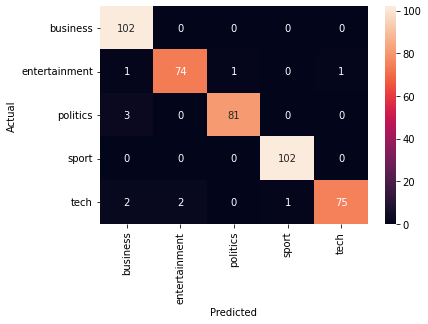

In [25]:
show_confusion_matrix(y_test, y_pred)

In [26]:
def validate_samples(texts, labels, model):   
    text_features = tfidf.transform(texts)
    predictions = model.predict(text_features)
    for text, predicted, actual in zip(texts, predictions, labels):
        print('"{}"'.format(text.replace('\n', ' ')))
        print(" - Predicted as: '{}'".format(labels_to_category[predicted]))
        print(" - Actual is: '{}'".format(labels_to_category[actual]))

In [27]:
sub_df = df.sample(n=5)
texts = sub_df['news']
actual_labels= sub_df['label']
validate_samples(texts, actual_labels, model)

"Israeli economy picking up pace    Israel's economy is forecast to grow by 4.2% in 2004 as it continues to emerge from a three-year recession.    The main driver of the faster-than-expected expansion has been exports, with tourism seeing a strong rebound, the statistical office said. The economy is benefiting from a quieter period in Palestinian-Israeli violence and a pick-up in global demand for technology products. The outlook is better than it has been for a number of years, analysts said.    Many companies have focused on cost cutting and greater efficiency, while the government has been trying to trim public spending and push through reforms. The growth figures come about despite a strike earlier this year by about 400,000 public sector worker which closed banks, hospitals, postal services and transport facilities. Growth did slow in the second half, but only slightly. Exports for the year rose by 14%, while tourist revenues were up by 30%. Imports gained by 13%, signalling that 

## Random Forest Classifier

In [28]:
model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=200, max_depth=3)

In [29]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=200, random_state=42)

In [30]:
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [31]:
print_metrics(model, y_test, y_pred)

*** Score for RandomForestClassifier(max_depth=3, n_estimators=200, random_state=42): ***
Accuracy: 0.84
Precision: 0.84
Recall: 0.84
F1 score: 0.84


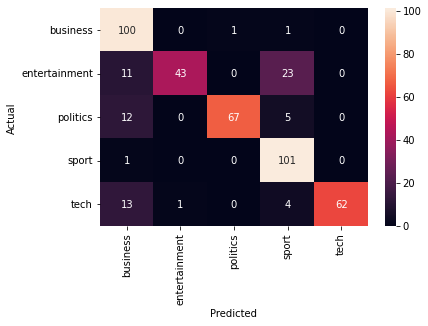

In [32]:
show_confusion_matrix(y_test, y_pred)

In [33]:
validate_samples(texts, actual_labels, model)

"Israeli economy picking up pace    Israel's economy is forecast to grow by 4.2% in 2004 as it continues to emerge from a three-year recession.    The main driver of the faster-than-expected expansion has been exports, with tourism seeing a strong rebound, the statistical office said. The economy is benefiting from a quieter period in Palestinian-Israeli violence and a pick-up in global demand for technology products. The outlook is better than it has been for a number of years, analysts said.    Many companies have focused on cost cutting and greater efficiency, while the government has been trying to trim public spending and push through reforms. The growth figures come about despite a strike earlier this year by about 400,000 public sector worker which closed banks, hospitals, postal services and transport facilities. Growth did slow in the second half, but only slightly. Exports for the year rose by 14%, while tourist revenues were up by 30%. Imports gained by 13%, signalling that 

# Deep learning

In [34]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size = 0.20, random_state = RANDOM_SEED,stratify=y)

In [36]:
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, return_tensors="pt")

In [37]:
class BbcDataset(torch.utils.data.Dataset):

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = { key: torch.tensor(val[idx]) for key, val in self.encodings.items() }
        item['labels'] = torch.tensor(self.labels[idx], device=DEVICE)
        return item

    def __len__(self):
        return len(self.labels)

In [38]:
train_dataset = BbcDataset(train_encodings, y_train.tolist())
test_dataset = BbcDataset(test_encodings, y_test.tolist())

In [39]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [40]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=df['label'].nunique())
model.classifier 
model.to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [41]:
training_args = TrainingArguments (
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    do_train=True,
    do_eval=True,
    logging_strategy='steps',
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps'
)

In [42]:
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [43]:
metric = datasets.load_metric('accuracy')

In [44]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optim, None),
    compute_metrics=compute_metrics
)

In [46]:
start_time = time.time()
trainer.train()
print('Total Training Time: {:.2f}'.format((time.time() - start_time)/60))

***** Running training *****
  Num examples = 1780
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 112


Step,Training Loss,Validation Loss,Accuracy
10,1.479300,1.172808,0.896629
20,0.898600,0.654520,0.912360
30,0.511800,0.327582,0.961798
40,0.298000,0.212150,0.957303
50,0.220500,0.155531,0.968539
60,0.184300,0.136535,0.970787
70,0.114800,0.101093,0.979775
80,0.174900,0.095278,0.977528
90,0.127100,0.137186,0.966292
100,0.144100,0.116335,0.975281


***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16
***** Running Evaluation *****
  Num examples = 445
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




Total Training Time: 169.59


In [49]:
save_directory = "./models/BestDistilBertModel"
model.save_pretrained(save_directory)

Configuration saved in ./models/BestDistilBertModel/config.json
Model weights saved in ./models/BestDistilBertModel/pytorch_model.bin


In [50]:
model = DistilBertForSequenceClassification.from_pretrained(save_directory)

loading configuration file ./models/BestDistilBertModel/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.22.2",
  "vocab_size": 30522
}

loading weights file ./models/BestDistilBertModel/pytorc

In [54]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for batch_idx, batch in enumerate(data_loader):
            input_idx = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_idx, attention_mask=attention_mask)
            logits = outputs['logits']
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
    return correct_pred.float()/num_examples * 100

In [55]:
model.eval()
model.to(DEVICE)
print('Test accuracy: {:.2f}%'.format(compute_accuracy(model, test_loader, DEVICE)))

Test accuracy: 97.75%


In [53]:
print(trainer.evaluate())

***** Running Evaluation *****
  Num examples = 445
  Batch size = 16


{'eval_loss': 0.10385508835315704, 'eval_accuracy': 0.9775280898876404, 'eval_runtime': 450.9732, 'eval_samples_per_second': 0.987, 'eval_steps_per_second': 0.062, 'epoch': 1.0}


# Conclusion

Both approaches (Machine Learning and Deep Learning) allow to get high model qualitity (98% accuracy for DistilBert model and Logistic Regression), but neural network required much more computational resources. And despite the neural network can provide potentially the best quality, for quick analysis in the particular case simple vanilla machine learning methods seem to be preferable to use.